# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [32]:
# Load the data
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [33]:
import numpy as np

X_versi = X[:, :2] 
y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

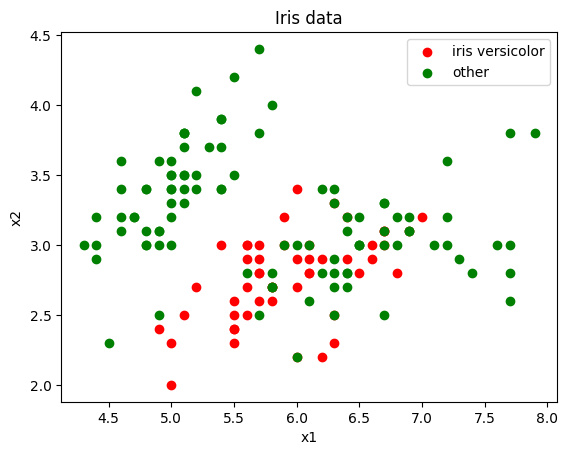

In [34]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [36]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    except AttributeError:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

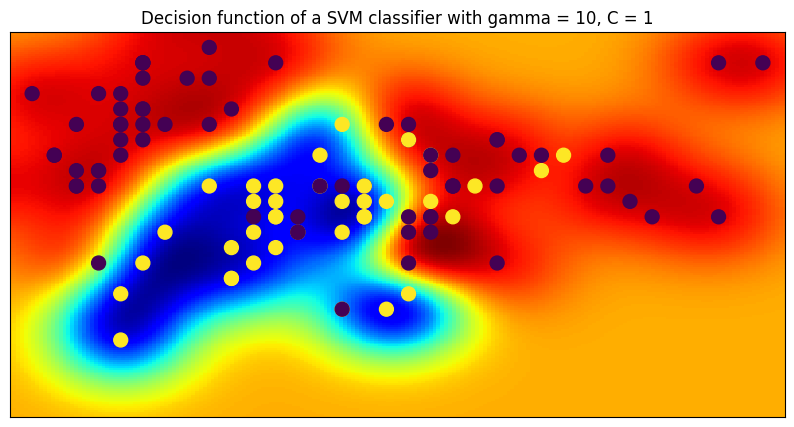

In [37]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1, probability=True)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1');

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [38]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train an SVM classifier on the training data
clf_svm = SVC(kernel='linear', random_state=3)
clf_svm.fit(X_train, y_train)

# Classify the test data using the trained SVM model
y_pred_svm = clf_svm.predict(X_test)

# Evaluate the classification performance
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

# Print the classification report
report = classification_report(y_test, y_pred_svm, target_names=['Other', 'Iris Versicolor'])

print("Classification Performance of the SVM Model:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nDetailed Classification Report:")
print(report)



Classification Performance of the SVM Model:
Accuracy: 0.74
Precision: 0.62
Recall: 0.42
F1-Score: 0.50

Detailed Classification Report:
                 precision    recall  f1-score   support

          Other       0.77      0.88      0.82        26
Iris Versicolor       0.62      0.42      0.50        12

       accuracy                           0.74        38
      macro avg       0.70      0.65      0.66        38
   weighted avg       0.72      0.74      0.72        38




### Interpretation of Metrics

- **Accuracy**: This metric provides an overall measure of how often the classifier is correct. While it is useful, it can be misleading in cases of imbalanced datasets where the majority class dominates.

- **Precision**: This metric is important when the cost of false positives is high. In the context of identifying "Iris Versicolor," high precision means that most of the instances predicted as "Iris Versicolor" are actually "Iris Versicolor."

- **Recall**: This metric is crucial when the cost of false negatives is high. For example, if missing an "Iris Versicolor" instance is more critical, then a higher recall is preferred.

- **F1-Score**: This metric provides a balance between precision and recall. It is useful when both false positives and false negatives are important to minimize.

### Most Meaningful Metric to Report

The most meaningful metric to report depends on the specific context and the relative importance of precision and recall. In this case:

- **If false positives (predicting "Iris Versicolor" when it is not) are more critical**: Precision would be more important.
- **If false negatives (missing "Iris Versicolor") are more critical**: Recall would be more important.
- **For a balanced perspective**: The F1-score is a good measure to report as it considers both precision and recall.

Given the relatively balanced classes in this dataset, the F1-score provides a good single measure of the model's performance.

### Conclusion

The SVM classifier has moderate performance in identifying "Iris Versicolor" with an F1-score of 0.50. Precision is higher than recall, indicating the model is better at correctly predicting positive instances than it is at identifying all actual positives. Reporting the F1-score along with precision and recall provides a comprehensive view of the model's performance. 


#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [39]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

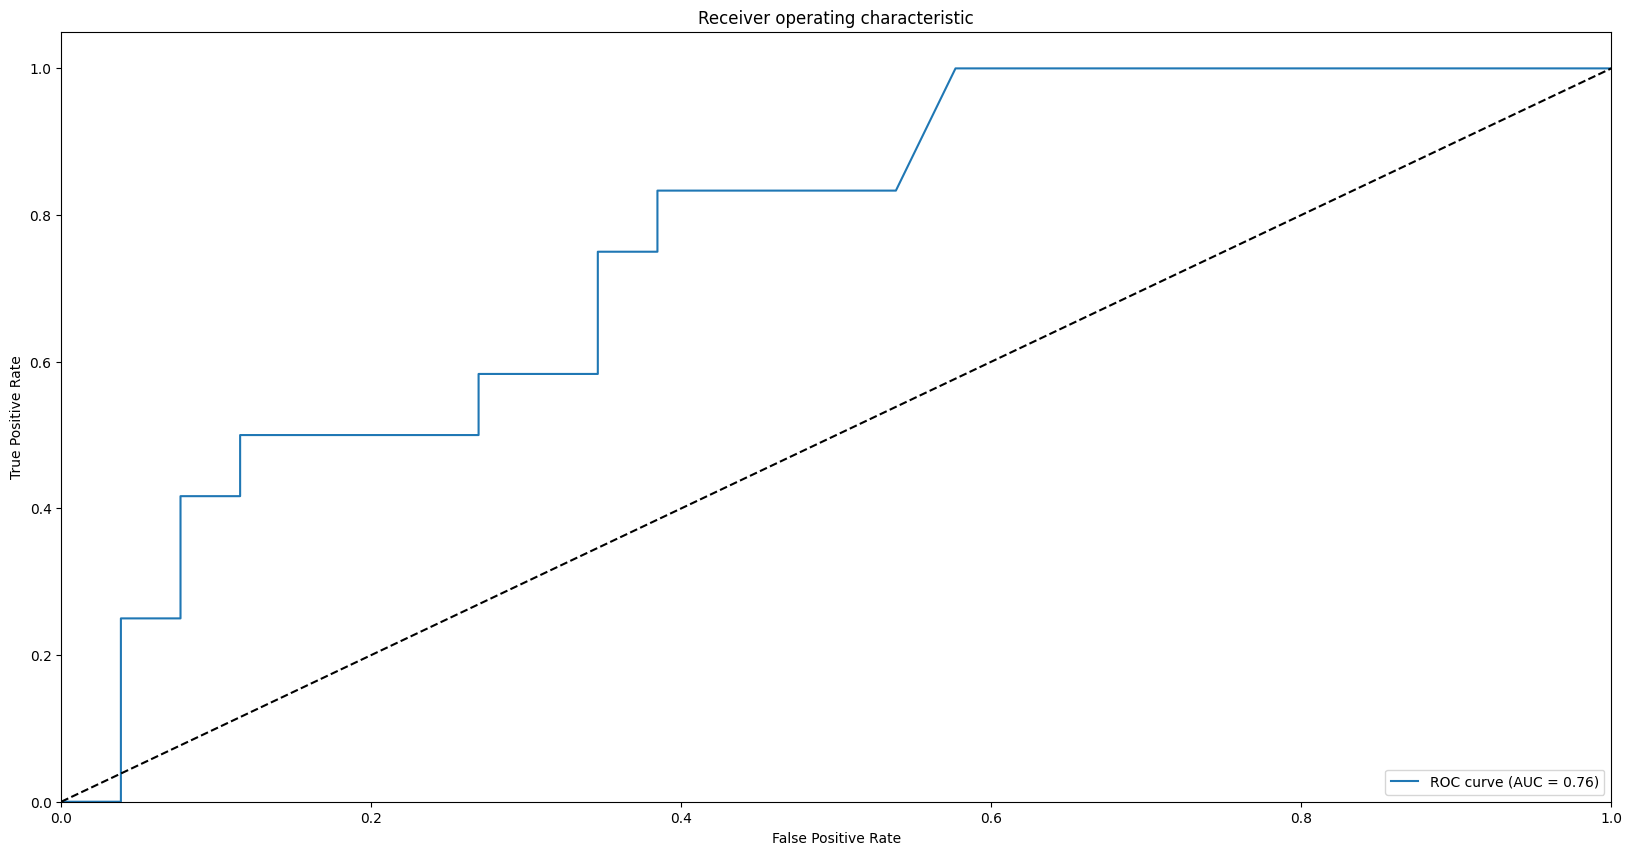

AUC: 0.7628205128205128


In [40]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rates and true positive rates
y_score = clf_svm.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using the provided function
def plot_roc_curves(fprs, tprs):
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function with calculated fpr and tpr
plot_roc_curves([fpr], [tpr])

# Print the AUC value
print("AUC:", roc_auc)


#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [41]:
from sklearn.svm import SVC

# List to store the classifiers
clfs = []

# Range of values for the regularization parameter C
C_values = [0.1, 1, 10, 100]

# Train SVM models with different values of C and gamma set to 10
for C in C_values:
    clf = SVC(kernel='linear', C=C, gamma=10, random_state=3)
    clf.fit(X_train, y_train)
    clf.name = f"SVM with C={C}"
    clfs.append(clf)

# Print the names of the trained classifiers
for clf in clfs:
    print(clf.name)



SVM with C=0.1
SVM with C=1
SVM with C=10
SVM with C=100


Let's have a look at the decision functions of the four classifiers...

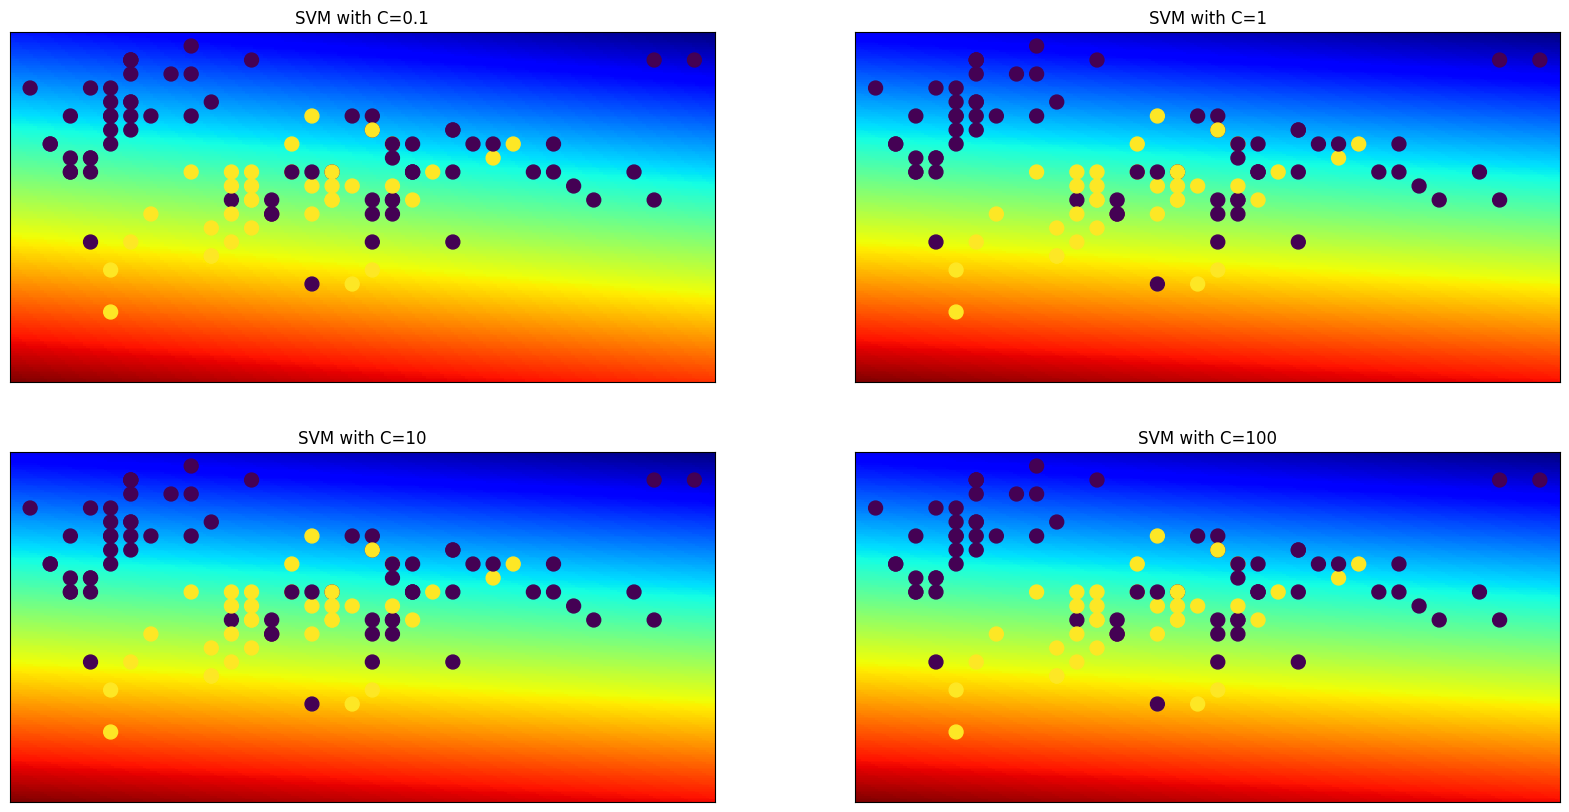

In [42]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

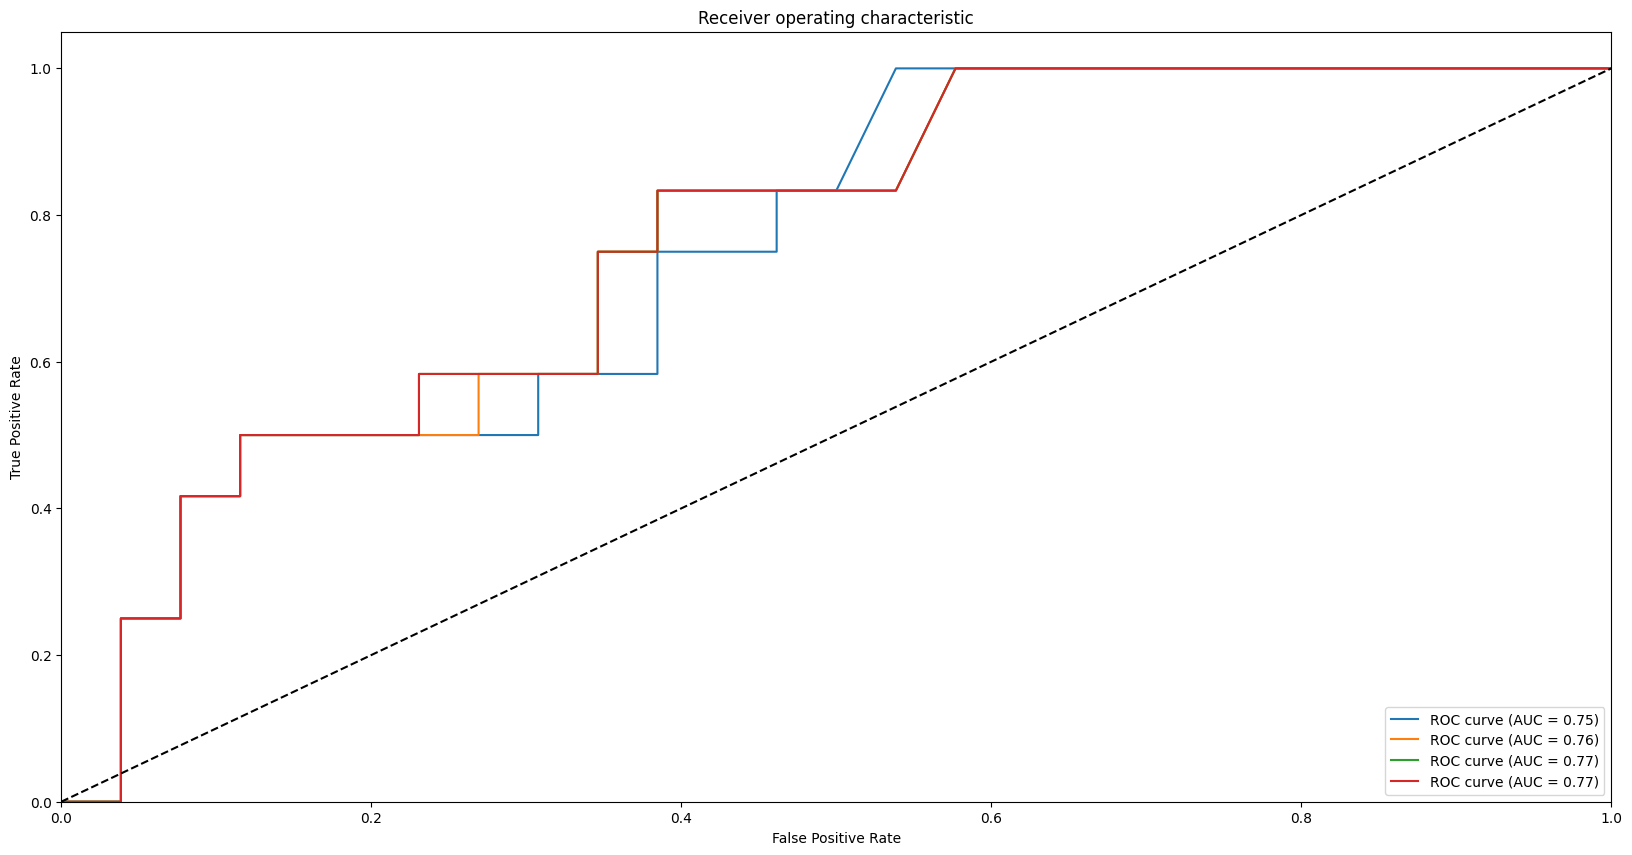

In [43]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)

## 2. Hyperparameter Tuning

Many models have hyperparameters, parameters that can't directly be estimated from the data. They have to be manually tuned by the practioner, because there is no analytical formula available to calculate an appropriate value. One example is the regularization parameter $C$ in SVMs.

#### Exercise 2.1 (Nested cross-validation)

Train a SVM classifier for the detection of iris versicolor again, but this time with a proper tuning of the regularization parameter $C$ (you may set the gamma parameter to 10 again). Select a reasonable range of parameter values for $C$ and implement a nested cross-validation (as shown on the slides) by yourself. 

You can use the following helper function that creates a list of masks. Each mask can be used as an index set to select the test samples. The function accepts the number of samples *num_samples* in the dataset and the desired number of folds *k* as input parameters. Since the data is sorted by the labels the k-fold CV will likely have trouble with class imbalances in the some cases. So you should randomly shuffle the data before applying the masks.

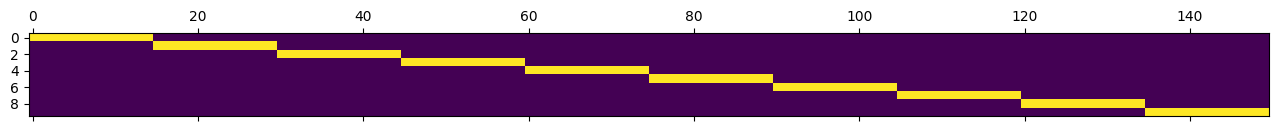

In [44]:
# helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples / k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*int(fold_size):(i+1)*int(fold_size)] = True
        masks.append(mask)
        
    return masks

# visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(150, 10)
plt.matshow(masks)

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Range of C values to test
C_values = [0.01, 0.1, 1, 10, 100]

# Number of folds for outer and inner cross-validation
k_outer = 5
k_inner = 3

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=42)

# Shuffle the training data to handle class imbalances
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]

# Create k-fold masks for outer cross-validation
outer_masks = create_kfold_mask(len(y_train), k_outer)

best_C = None
best_score = 0

# Outer loop
for outer_mask in outer_masks:
    X_train_outer, X_val_outer = X_train[~outer_mask], X_train[outer_mask]
    y_train_outer, y_val_outer = y_train[~outer_mask], y_train[outer_mask]
    
    best_inner_C = None
    best_inner_score = 0
    
    # Inner loop
    inner_masks = create_kfold_mask(len(y_train_outer), k_inner)
    for C in C_values:
        inner_scores = []
        for inner_mask in inner_masks:
            X_train_inner, X_val_inner = X_train_outer[~inner_mask], X_train_outer[inner_mask]
            y_train_inner, y_val_inner = y_train_outer[~inner_mask], y_train_outer[inner_mask]
            
            clf = SVC(kernel='linear', C=C, gamma=10, random_state=42)
            clf.fit(X_train_inner, y_train_inner)
            y_pred_inner = clf.predict(X_val_inner)
            inner_scores.append(accuracy_score(y_val_inner, y_pred_inner))
        
        mean_inner_score = np.mean(inner_scores)
        if mean_inner_score > best_inner_score:
            best_inner_score = mean_inner_score
            best_inner_C = C
    
    clf = SVC(kernel='linear', C=best_inner_C, gamma=10, random_state=42)
    clf.fit(X_train_outer, y_train_outer)
    y_pred_outer = clf.predict(X_val_outer)
    outer_score = accuracy_score(y_val_outer, y_pred_outer)
    
    if outer_score > best_score:
        best_score = outer_score
        best_C = best_inner_C

# Train the final model with the best C found
final_clf = SVC(kernel='linear', C=best_C, gamma=10, random_state=42)
final_clf.fit(X_train, y_train)
y_pred = final_clf.predict(X_test)

# Evaluate the final model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Best C value: {best_C}")
print(f"Test set accuracy: {accuracy:.2f}")


Best C value: 10
Test set accuracy: 0.71
